In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Data

In [2]:
from covid19be import load_data
data = load_data()

In [3]:
data.tail(10)

,n_hospitalized,n_hospitalized_in,n_hospitalized_out,n_icu,n_daily_deaths,date,n_deaths
51,4892,265,409,1081,199,2020-04-18,5987
52,4940,232,138,1071,217,2020-04-19,6204
53,4996,172,106,1079,200,2020-04-20,6404
54,4765,263,432,1020,211,2020-04-21,6615
55,4527,211,367,993,195,2020-04-22,6810
56,4355,210,322,970,168,2020-04-23,6978
57,4195,217,295,934,135,2020-04-24,7113
58,3957,202,368,891,135,2020-04-25,7248
59,3968,127,93,903,78,2020-04-26,7326
60,3976,123,65,876,5,2020-04-27,7331


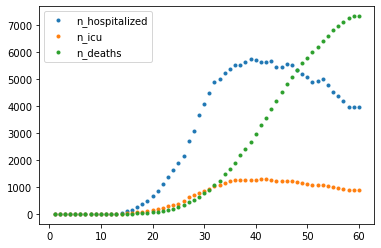

In [4]:
data[["n_hospitalized", "n_icu", "n_deaths"]].plot(style=".")

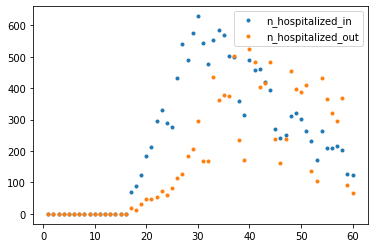

In [5]:
data[["n_hospitalized_in", "n_hospitalized_out"]].plot(style=".")

# SEIR model

Python re-implementation of Nicolas' original SEIR model.

In [6]:
hyper_parameters = {
    "frac_dh": 2985 / 6490,  # deaths in hospitals / total deaths
    "hh": 0.05,              # fraction of hospitalized 
    "gamma": 1 / 12.4,       # inverse recovery time"
    "epsilon": 1 / 5.2,      # inverse incubation time 
    "dea": 0.5,              # fatality rate in icu 
    "n0": 11000000,          # population size
    "n0_MRS": 400000,        # population en MR/MRS + personnel soignant
    "window": 6,             # size of the window for fitting Re's"
}

def smoothen(v, n_pts=hyper_parameters["window"]):
    box = np.ones(n_pts) / n_pts
    return np.convolve(v, box, mode="same")

def SEIR(r0, i0=3, gg=0.75, n_futures=0, opts=hyper_parameters):   
    # Load hyper-parameters
    hh = opts["hh"]
    gamma = opts["gamma"]
    epsilon = opts["epsilon"]
    dea = opts["dea"]
    n0 = opts["n0"]
    n0_MRS = opts["n0_MRS"]
    window = opts["window"]
    
    # Smoothen and extend R0s
    r0 = smoothen(r0)
    r0 = np.concatenate((r0, np.array([r0[-1]] * (window + n_futures))))
    
    # Initial conditions
    drea = dea * 1 / 5
    rrea = (1 - dea) * 1 / 20
    hospi = 0.0
    
    n = [n0-n0_MRS]
    i = [i0]
    e = [i[-1] * 37]
    h = [0.0]
    l = [0.0]
    r = [0.0]
    m = [0.0]
    s = [n[-1] - e[-1] - i[-1] - r[-1]]
    
    # Simulate forward
    n_days = len(r0)
    
    for day in range(n_days):
        lam = gamma * r0[day]
        
        if day == 14:
            hospi = hh / 7
            
        ds = -lam * (i[-1] / 2 + e[-1]) * s[-1] / n[-1]
        de = lam * (i[-1] / 2 + e[-1]) * s[-1] / n[-1] - epsilon * e[-1]
        di = epsilon * e[-1] - gamma * i[-1] - hospi * i[-1]
        dh = hospi * i[-1] - gg * h[-1] / 7 - (1 - gg) * h[-1] / (4 + 2 * np.tanh((l[-1]-500)/300))
        dl = (1 - gg) * h[-1] / (4 + 2 * np.tanh((l[-1]-500)/300)) - drea * l[-1] - rrea * l[-1]
        dr = gamma * i[-1] + rrea * l[-1] + gg * h[-1] / 7
        dm = drea * l[-1] 
        
        s.append(s[-1] + ds)
        e.append(e[-1] + de)
        i.append(i[-1] + di)
        h.append(h[-1] + dh)
        l.append(l[-1] + dl)
        if l[-1] > 1895:
            dm = dm + (l[-1] - 1895)
            l[-1] = 1895
        r.append(r[-1] + dr)
        m.append(m[-1] + dm)
        n.append(s[-1] + e[-1] + i[-1] + h[-1] + l[-1] + r[-1])
        
    return np.array(s), np.array(e), np.array(i), np.array(h), np.array(l), np.array(m), np.array(r)

def SEIR_MRS(r0_mrs, n_futures=0, opts=hyper_parameters):
    # Load hyper-parameters
    gamma = opts["gamma"]
    epsilon = opts["epsilon"]
    n0_MRS = opts["n0_MRS"]
    window = opts["window"]
    
    # Smoothen and extend R0s
    r0_mrs = smoothen(r0_mrs)
    r0_mrs = np.concatenate((r0_mrs, np.array([r0_mrs[-1]] * (window + n_futures))))
    
    # Initial conditions
    alpha = 0.15 / 10
    lam = gamma * 4.3
    
    n = [n0_MRS]
    i = [1]
    e = [i[-1]*20]
    r = [0.0]
    s = [n[-1] - e[-1] - i[-1] - r[-1]]
    m = [0.0]
    
    # Simulate forward
    n_days = len(r0_mrs)
    
    for day in range(n_days):
        lam = gamma * r0_mrs[day]
        
        ds = -lam * (i[-1] / 2 + e[-1]) * s[-1] / n[-1]
        de = lam * (i[-1] / 2 + e[-1]) * s[-1] / n[-1] - epsilon * e[-1]
        di = epsilon * e[-1] - (gamma + alpha) * i[-1]
        dr = gamma * i[-1]
        dm = alpha * i[-1]
        
        s.append(s[-1] + ds)
        e.append(e[-1] + de)
        i.append(i[-1] + di)
        r.append(r[-1] + dr)
        m.append(m[-1] + dm)
        n.append(s[-1] + e[-1] + i[-1] + r[-1])
        
    return np.array(s), np.array(e), np.array(i), np.array(m), np.array(r)   

def simulate(theta, n_futures=0):   
    # Unpack parameters
    r0, r0_mrs, i0, gg = theta
    
    # Simulate
    s, e, i, h, l, m, r = SEIR(r0, i0=i0, gg=gg, n_futures=n_futures)
    _, _, _, m_mrs, _ = SEIR_MRS(r0_mrs, n_futures=n_futures)
    
    return s, e, i, h, l, m, m_mrs, r

In [7]:
# Log-likelihood functions and samplers
from scipy.stats import norm, poisson
from scipy.special import gammaln

def normal_logpdf(x, mu, sigma=1):
    return norm.logpdf(x, loc=mu, scale=sigma).sum()

def normal_rvs(mu, sigma=1, random_state=None):
    return norm.rvs(loc=mu, scale=sigma, random_state=random_state)

def sqrt_normal_logpdf(x, mu, sigma=1):
    return norm.logpdf(x ** 0.5, loc=mu ** 0.5, scale=sigma).sum()

def sqrt_normal_rvs(mu, sigma=1, random_state=None):
    return norm.rvs(loc=mu ** 0.5, scale=sigma, random_state=random_state) ** 2

def poisson_logpdf(x, mu, sigma=None):
    #return poisson.logpmf(x, mu).sum()
    return (x * np.log(mu.astype(float) + 1e-10) - mu - gammaln(x.astype(float) + 1e-10)).sum()

def poisson_rvs(mu, sigma=None, random_state=None):
    return poisson.rvs(mu, random_state=random_state)

# Parameter fit

The procedure is different from Nicolas'. All parameters are fit jointly, instead of using a greedy procedure to fit parameters sequentially. Results are therefore slightly different.

In [8]:
from scipy.optimize import minimize

# Pack-unpack helpers for passing parameters around
def pack(r0, r0_rms, i0, gg):
    v = np.zeros(len(r0) + len(r0_rms) + 2)
    v[:len(r0)] = r0
    v[len(r0):len(r0)+len(r0_rms)] = r0_rms
    v[-2] = i0
    v[-1] = gg
    return v 

def unpack(v):
    return v[:(len(v)-2)//2], v[(len(v)-2)//2:len(v)-2], v[-2], v[-1]

# Fit
def fit(data, logpdf=poisson_logpdf, opts=hyper_parameters):
    # Load hyper-parameters
    window = opts["window"]
    frac_dh = opts["frac_dh"]
    
    # Cost
    def cost(x):
        # parameters
        r0, r0_mrs, i0, gg = unpack(x)

        # cost
        c = 0.0

        s, e, i, h, l, m, r = SEIR(r0, i0=i0, gg=gg)
        c -= logpdf(data["n_hospitalized"].values[9:], mu=h[10:]+l[10:])
        c -= logpdf(data["n_icu"].values[9:], mu=l[10:])
        c -= logpdf(frac_dh * data["n_deaths"].values[9:-2], mu=m[10:-2])

        # fit on deaths with SEIR_MRS
        s, e, i, m_mrs, r = SEIR_MRS(r0_mrs)
        c -= logpdf(data["n_deaths"].values[:-2], mu=m[1:-2] + m_mrs[1:-2])

        # ^ we omit the last two death data points, because not consolidated yet

        return c
 
    # x0
    r0 = [4.3] * (len(data) - window)
    r0_rms = [4.3] * (len(data) - window)
    i0 = 3.0
    gg = 0.75
    x0 = pack(r0, r0_rms, i0, gg)

    # bounds
    bounds = []
    for _ in range(len(r0)):
        bounds.append((0.25, 5.0))
    for _ in range(len(r0_rms)):
        bounds.append((0.25, 10.0))
    bounds.append((1, 50))
    bounds.append((0.65, 0.85))

    # fit
    res = minimize(cost, x0=x0, bounds=bounds, options={"maxfun": 25000})
    
    return unpack(res.x)

In [9]:
theta = fit(data, logpdf=poisson_logpdf)
r0, r0_mrs, i0, gg = theta
print(r0)
print(r0_mrs)
print(i0)
print(gg)

[4.99778681 4.99728403 4.99388045 4.96595637 4.95201522 4.81352259
 4.9967113  4.99654051 4.99626783 4.62870065 3.87467388 3.22609117
 2.78550489 2.19711985 2.49237914 3.316643   3.43149336 3.89687958
 4.41887385 4.8310239  4.89803732 4.41112531 3.21551419 1.32016446
 0.42864407 0.25       0.25       0.25       0.25       0.25
 0.25       0.25       0.25       0.26013312 0.69762133 1.11738483
 0.42722192 0.86783252 1.11148565 1.19665067 1.13890826 1.21207643
 1.00131638 0.82826536 0.71050861 0.66378965 0.62118133 0.9000928
 0.25084461 0.25087873 0.58934325 0.36811986 0.2972398  1.38613496]
[3.34661779 3.79273914 4.25776677 4.30506128 4.37236037 4.45466231
 4.55131001 4.6410621  4.71978984 4.78247747 4.82499645 4.84705937
 4.84615451 4.82241627 4.77634528 4.70920548 4.62508952 4.52172443
 4.40428001 4.27444873 4.13249361 3.98294249 3.83544216 3.69422392
 3.56300991 3.43907851 3.32212645 3.19397988 3.04427825 2.85106955
 2.60839496 2.30761233 1.94455561 1.51963924 1.04727457 0.54195241
 

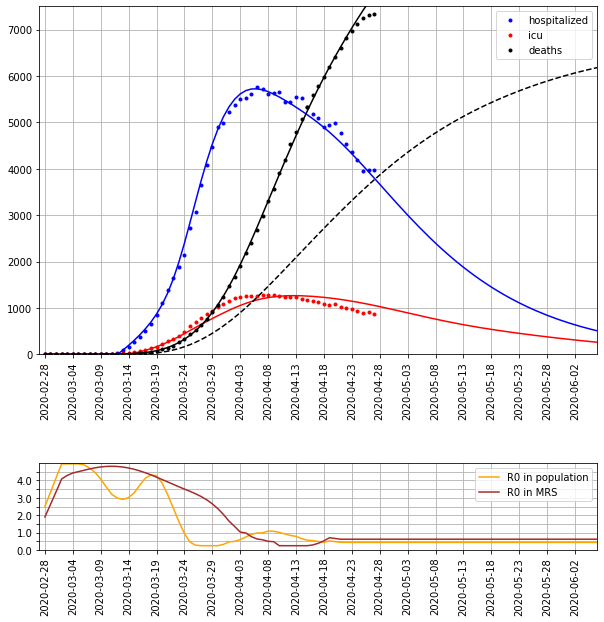

In [10]:
# Plots
n_futures = 365
s, e, i, h, l, m, m_mrs, r = simulate(theta, n_futures=n_futures)
n_days = len(data)

fig, ax = plt.subplots(2, 1, figsize=(10, 10), gridspec_kw={"height_ratios": (4,1)})

# Plot hospitalizations, icus and deaths
ax[0].plot(range(1, n_days+1 + n_futures), h[1:]+l[1:], c="b")
ax[0].plot(range(1, n_days+1), data["n_hospitalized"].values, ".", c="b", label="hospitalized")
ax[0].plot(range(1, n_days+1 + n_futures), l[1:], c="r")
ax[0].plot(range(1, n_days+1), data["n_icu"].values, ".", c="r", label="icu")
ax[0].plot(range(1, n_days+1 + n_futures), m[1:] + m_mrs[1:], c="k")
ax[0].plot(range(1, n_days+1 + n_futures), m[1:], "--", c="k")
ax[0].plot(range(1, n_days+1), data["n_deaths"].values, ".", c="k", label="deaths")
ax[0].grid()
ax[0].set_ylim(0, 7500)
ax[0].set_xlim(0, 100)
ax[0].set_xticks(np.arange(1, 100, 5))
ax[0].set_xticklabels([d.strftime('%Y-%m-%d') for d in pd.date_range(start="2020-02-28", end="2020-12-31")[:100:5]], rotation=90)
ax[0].legend()

# Plots R0s
window = hyper_parameters["window"]
_r0 = smoothen(r0)
_r0_mrs = smoothen(r0_mrs)
_r0 = np.concatenate((_r0, np.array([_r0[-1]] * (window + n_futures))))
_r0_mrs = np.concatenate((_r0_mrs, np.array([_r0_mrs[-1]] * (window + n_futures))))

ax[1].plot(range(1, n_days+1 + n_futures), _r0, c="orange", label="R0 in population")
ax[1].plot(range(1, n_days+1 + n_futures), _r0_mrs, c="brown", label="R0 in MRS")
ax[1].grid(which="both")
ax[1].set_ylim(0, 5)
ax[1].set_yticks(np.arange(0, 5, step=0.5))

for j, label in enumerate(ax[1].get_yticklabels()):
    if j % 2 != 0:
        label.set_visible(False)
ax[1].set_xlim(0, 100)
ax[1].set_xticks(np.arange(1, 100, 5))
ax[1].set_xticklabels([d.strftime('%Y-%m-%d') for d in pd.date_range(start="2020-02-28", end="2020-12-31")[:100:5]], rotation=90)
ax[1].legend()

plt.subplots_adjust(hspace=0.5)

#plt.savefig("plot.png")
plt.show()